In [1]:
from IPython.display import display

In [5]:
import geopandas as gp
import pandas as pd

# pts_gpdf_bfr = gp.read_file('pts_gpdf.geojson')

In [4]:
venues_gpdf_bfr = gp.read_file('venues_gpdf_bfr.geojson')

In [6]:
pts_gpdf_bfr.category = pts_gpdf_bfr.category.apply(eval)
pts_gpdf_bfr.tag=pts_gpdf_bfr.tag.apply(eval)
venues_gpdf_bfr.category = venues_gpdf_bfr.category.apply(eval)

In [7]:
fq_pts = gp.tools.sjoin(pts_gpdf_bfr, venues_gpdf_bfr)
fq_pts.shape

(3952, 11)

In [8]:
import sys, os
sys.path.insert(0, os.path.abspath('../../'))
from Cycling_Safe.utils.str_similarity import similarity

In [9]:
fq_pts['name_left'] = fq_pts.tag_left.apply(lambda x: x.get('name',''))
fq_pts['name_sml'] = fq_pts.apply(lambda x: similarity(x.name_left, x['name']),axis=1)


In [16]:
fq_pts_sml = fq_pts[(fq_pts.name_sml<0.8)]
fq_pts_sml
# fq_pts_sml[fq_pts_sml.apply(lambda x: len(x.category_right - x.category_left)==0 and len(x.category_left - x.category_right)!=0 , axis=1)]

,category_left,geometry,id_left,tag_left,type_left,index_right,category_right,id_right,name,tag_right,type_right,name_left,name_sml
8,set([cycling facilities]),POLYGON ((-77.00900476913097 38.88750470445696...,49716664,"{u'source': u'Bing', u'highway': u'crossing'}",Node,9933,set([professional service]),4be09e4c98f2a5931cd8c25a,Office of Rep. Chris Van Hollen (MD-08),Government Building,fq,,-1.000000
22,set([cycling facilities]),POLYGON ((-77.05696555480179 38.90525342812081...,49719415,{u'highway': u'traffic_signals'},Node,1366,set([retail shop]),5391f13f498e8a555acb7023,Ike Behar,Men's Store,fq,,-1.000000
58,set([cycling facilities]),POLYGON ((-77.05805425481758 38.90523442865798...,49732053,{u'highway': u'traffic_signals'},Node,1337,set([professional service]),4bc0fb9874a9a593f019d1f6,Wells Fargo,Bank,fq,,-1.000000
64,set([cycling facilities]),"POLYGON ((-77.02800236543074 38.8920883138304,...",49732286,{u'highway': u'traffic_signals'},Node,9176,set([art]),4c27ccfc97d00f4725f13eea,Michael Jackson's Fedora @Apollo Exhibit,Art Gallery,fq,,-1.000000
9321,set([cycling facilities]),POLYGON ((-77.02814476543053 38.89208861390066...,3016605404,{u'highway': u'traffic_signals'},Node,9176,set([art]),4c27ccfc97d00f4725f13eea,Michael Jackson's Fedora @Apollo Exhibit,Art Gallery,fq,,-1.000000
72,set([cycling facilities]),POLYGON ((-77.01360948760406 38.86462800672898...,49734010,{u'highway': u'stop'},Node,11557,set([professional service]),4de4542fd164df8575287ffe,National Response Center,Government Building,fq,,-1.000000
76,set([cycling facilities]),POLYGON ((-77.04331293640715 38.92800152138454...,49734611,{u'highway': u'traffic_signals'},Node,12713,set([cycling facilities]),4e54f80ad4c0fe0342802d27,Adams Mill & Harvard Bikestation,Bike Rental / Bike Share,fq,,-1.000000
77,set([cycling facilities]),POLYGON ((-77.03876393272729 38.93255011914005...,49734612,"{u'source': u'survey', u'highway': u'traffic_s...",Node,12038,set([retail shop]),4be0a15bcb81c9b6bb7e668b,Lamont Cleaners,Laundry Service,fq,,-1.000000
10139,set([professional service]),POLYGON ((-77.03892363276702 38.93250101921883...,3378524030,"{u'operator': u'United States Postal Service',...",Node,12038,set([retail shop]),4be0a15bcb81c9b6bb7e668b,Lamont Cleaners,Laundry Service,fq,,-1.000000
11197,set([cycling facilities]),POLYGON ((-77.03888013276854 38.93249911919739...,4082394066,"{u'stop': u'minor', u'highway': u'stop'}",Node,12038,set([retail shop]),4be0a15bcb81c9b6bb7e668b,Lamont Cleaners,Laundry Service,fq,,-1.000000


In [43]:
def connected_nodes(edges):
    import networkx as nx
    G = nx.Graph()
    G.add_edges_from(edges)
    return [x.nodes() for x in nx.connected_component_subgraphs(G)]
def similar_name(row,threshold=0.8):
    return row.name_sml>threshold
def no_name_but_same_category(row):
    if not row.name_sml==-1.0:
        return False
    return len(row.category_right - row.category_left)==0

In [111]:

pairs = fq_pts[['id_left','id_right']].values
conn_nodes = connected_nodes(pairs)
print len(conn_nodes)
mask_df = lambda df, x: df[(df.id_left.isin(x))|df.id_right.isin(x)]
over_lap_dfs = []
for idx,x in enumerate(conn_nodes):
    x = set(x)
    mask = mask_df(fq_pts,x)
    assert set(mask[['id_left','id_right']].values.flatten())==x, (idx, x,mask)
    mask_name_sml = mask[mask.apply(similar_name,axis=1)].copy()
    if mask_name_sml.shape[0]>0:
        mask_name_sml['criteria'] = 'similar name'
        mask_name_sml['component_idx'] = idx
        over_lap_dfs.append(mask_name_sml)
    else:
        mask_same_cateory = mask[mask.apply(no_name_but_same_category,axis=1)].copy()
        mask_same_cateory['criteria'] = 'same category'
        mask_same_cateory['component_idx'] = idx
        over_lap_dfs.append(mask_same_cateory)    
    
fq_pts_overlap = pd.concat(over_lap_dfs)

1882


In [114]:
overlap_nodeid = pd.unique(fq_pts_overlap.id_left)
overlap_fqid = pd.unique(fq_pts_overlap.id_right)
overlap_nodeid.shape, overlap_fqid.shape

((513L,), (521L,))

In [110]:
over_lap_df[['category_left','category_right','name_left','name','name_sml','criteria','component_idx','tag_left','id_left','id_right']].to_csv('over_lap_df',encoding='utf-8')

In [81]:
pd_over_lap_df = pd.DataFrame(over_lap_df,columns=['name_sml','no_nm_sm_ctgry','df'])

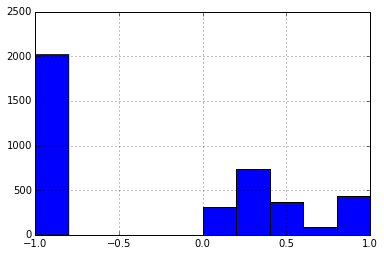

In [11]:
%matplotlib inline
fq_pts.apply(lambda x: similarity(x.name_left, x['name']),axis=1).hist()

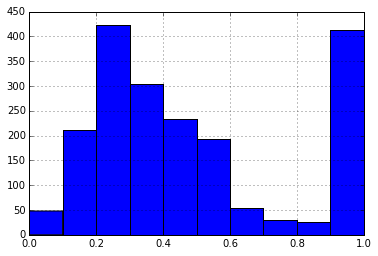

In [13]:
fq_pts[fq_pts.name_sml>-1].name_sml.hist()